# Imports, data loading, and functions #

In [105]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import random
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import supervised_learning_functions as fn

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(mh)
except NameError: # It hasn't been imported yet
    import mh_functions as mh
    
data_directory = 'C:/Users/61407/mental-health-modelling/data'
db = 'mental_health.sqlite'

con = sqlite3.connect(os.path.join(data_directory, db))
cur = con.cursor()

# Schema and data structure #

In [12]:
tables = cur.execute("""SELECT name FROM sqlite_master WHERE 
            type = 'table'""").fetchall()
print(tables)

[('Answer',), ('Question',), ('Survey',)]


In [13]:
for table_name in tables:
    name = table_name[0]
    table = pd.read_sql_query(f'SELECT * FROM {name}', con)
    print(f'{name} table:')
    print(f'keys: {list(table.columns)}')
    print(f'{table.shape[0]} rows')
    print()

Answer table:
keys: ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
236898 rows

Question table:
keys: ['questiontext', 'questionid']
105 rows

Survey table:
keys: ['SurveyID', 'Description']
5 rows



# EDA #

## 1. Investigation of questions ##

In [75]:
for idx, q in questions.iterrows():
    print(f'{q.questionid}. {q.questiontext}')

1. What is your age?
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
5. Are you self-employed?
6. Do you have a family history of mental illness?
7. Have you ever sought treatment for a mental health disorder from a mental health professional?
8. How many employees does your company or organization have?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
13. Is your primary role within your company related to tech/IT?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental hea

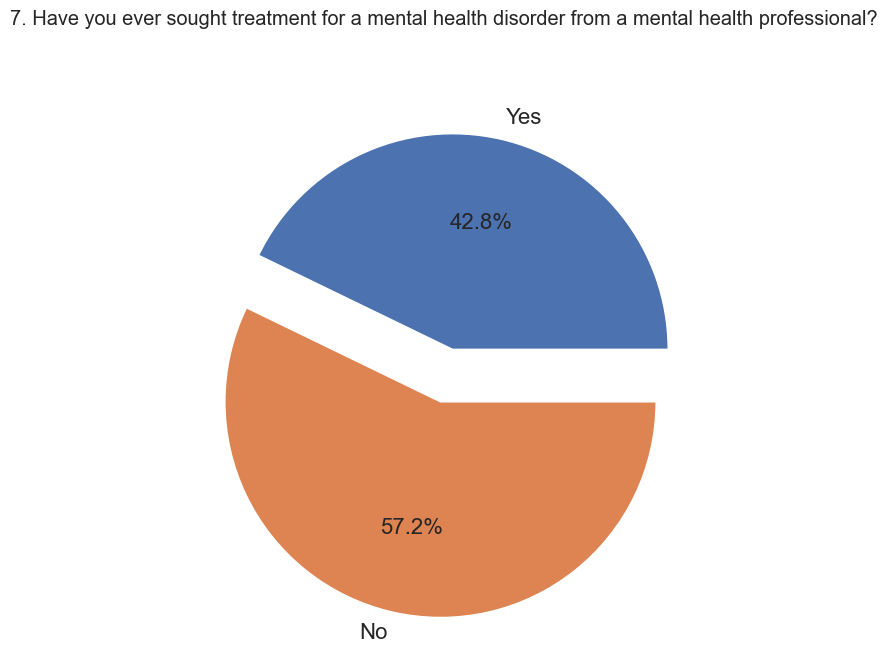

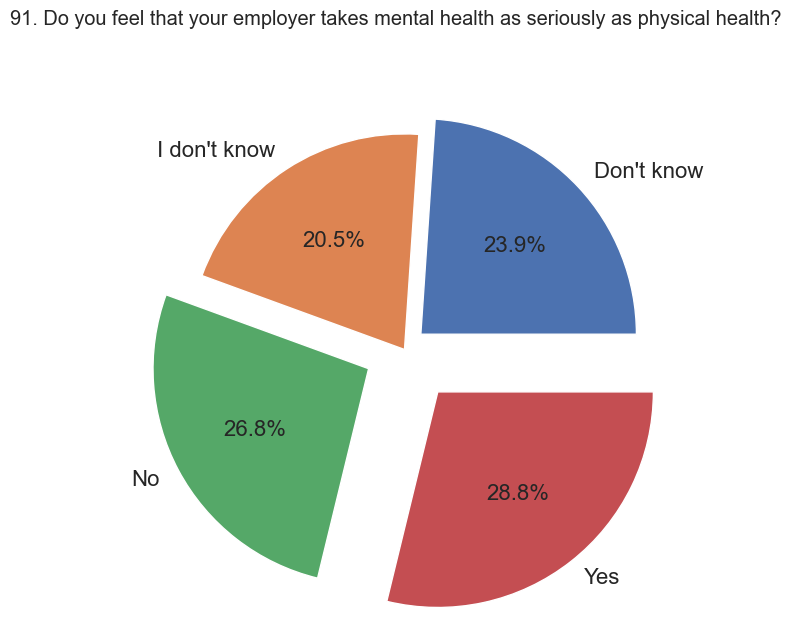

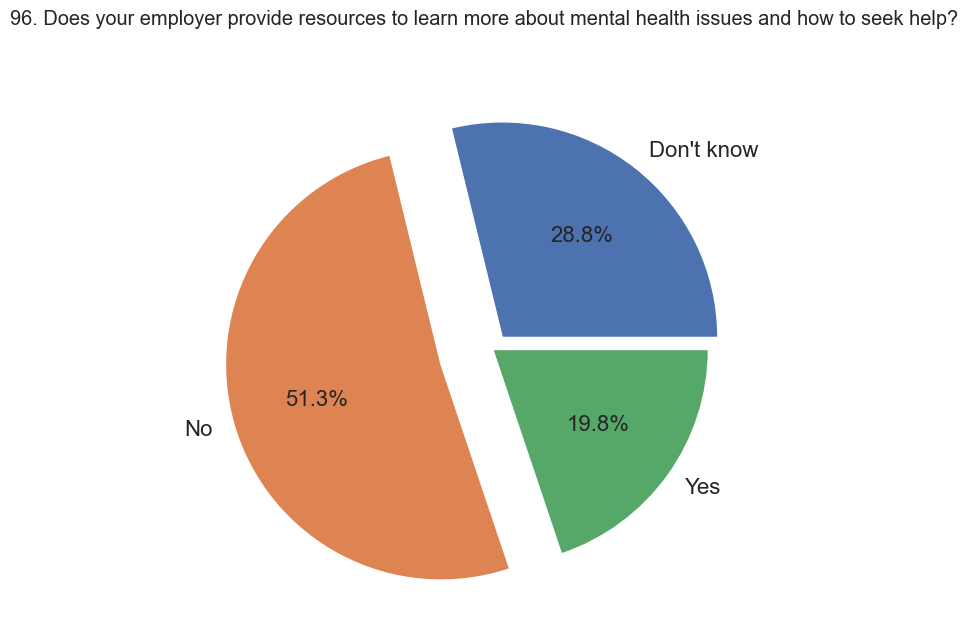

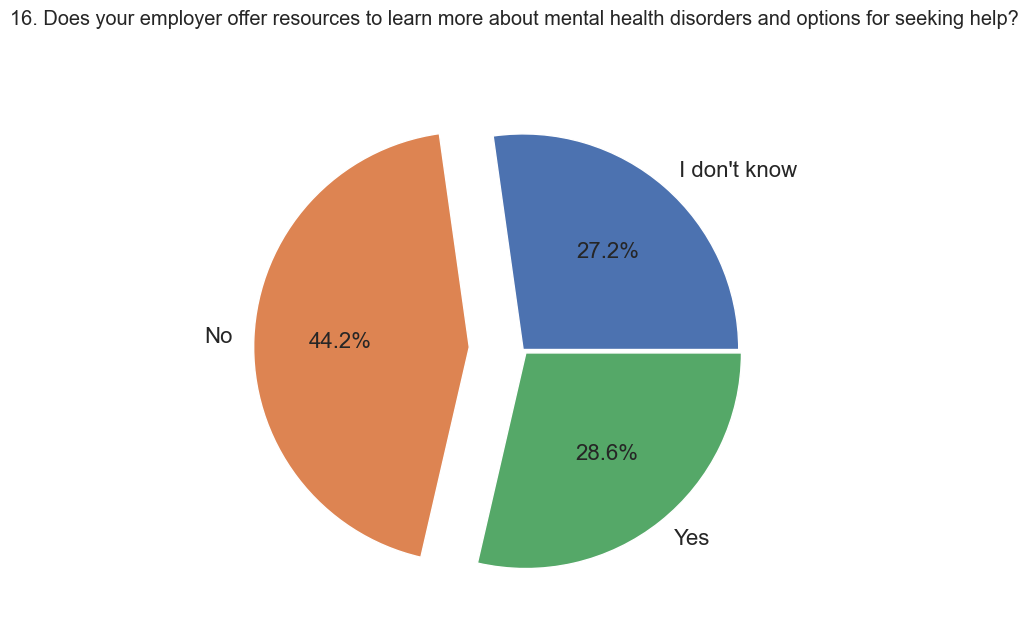

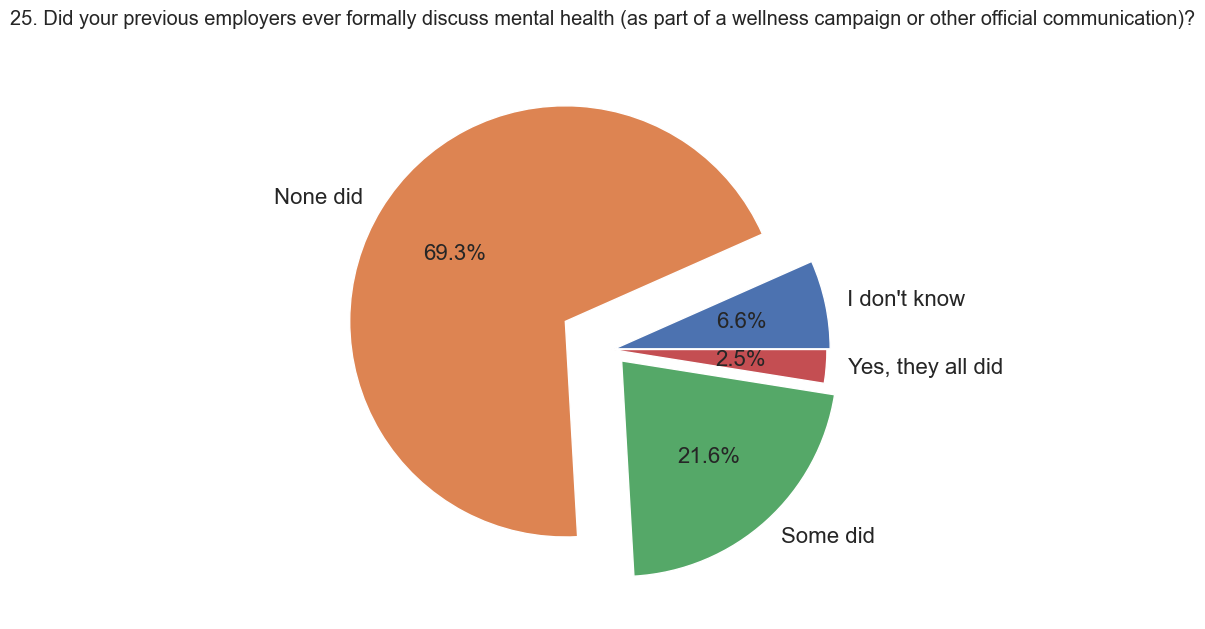

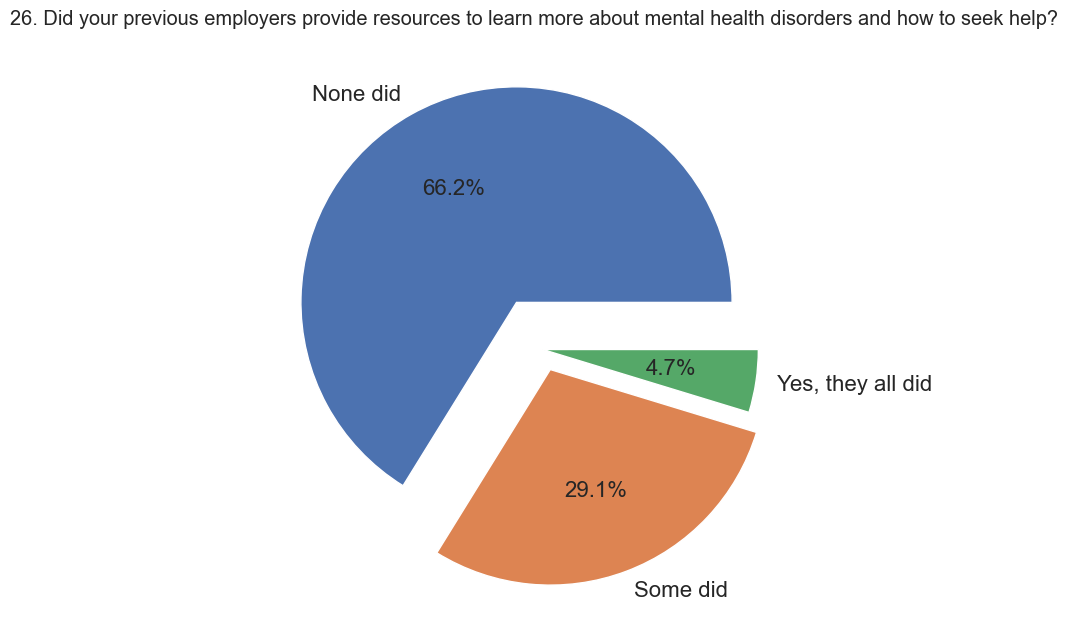

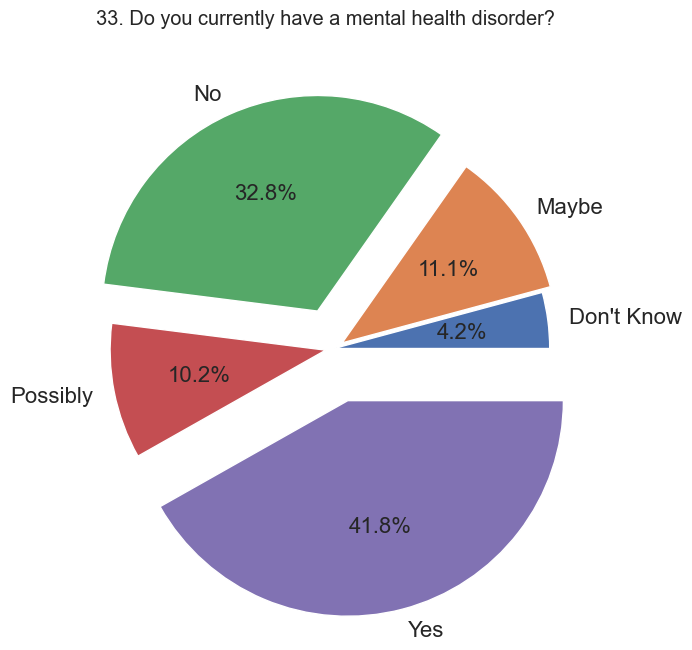

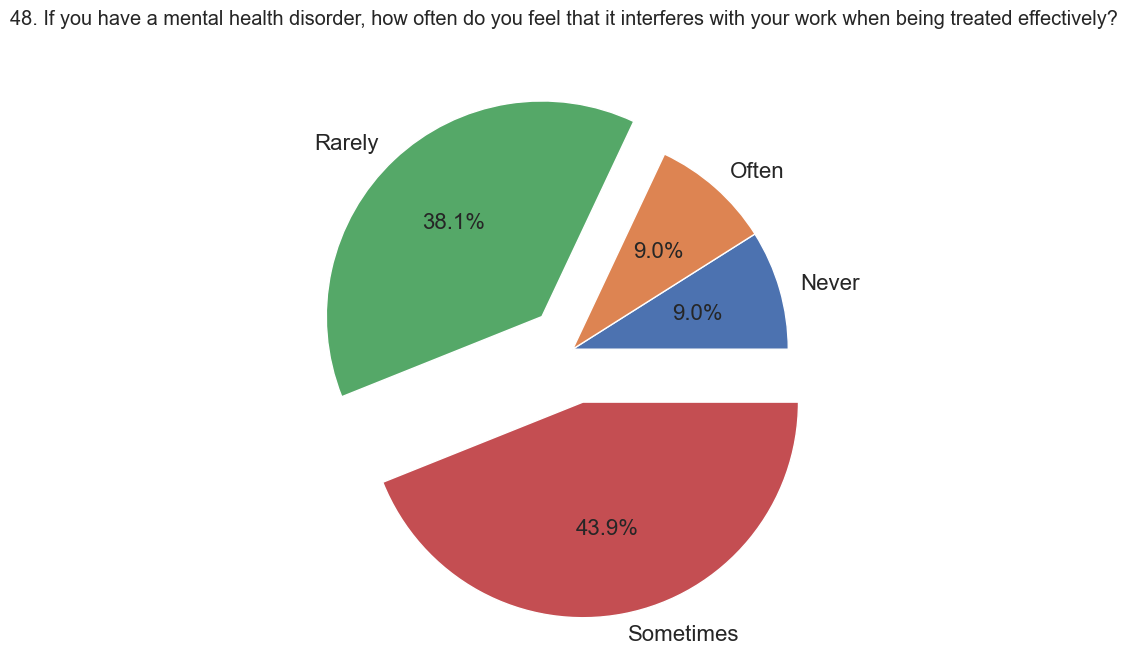

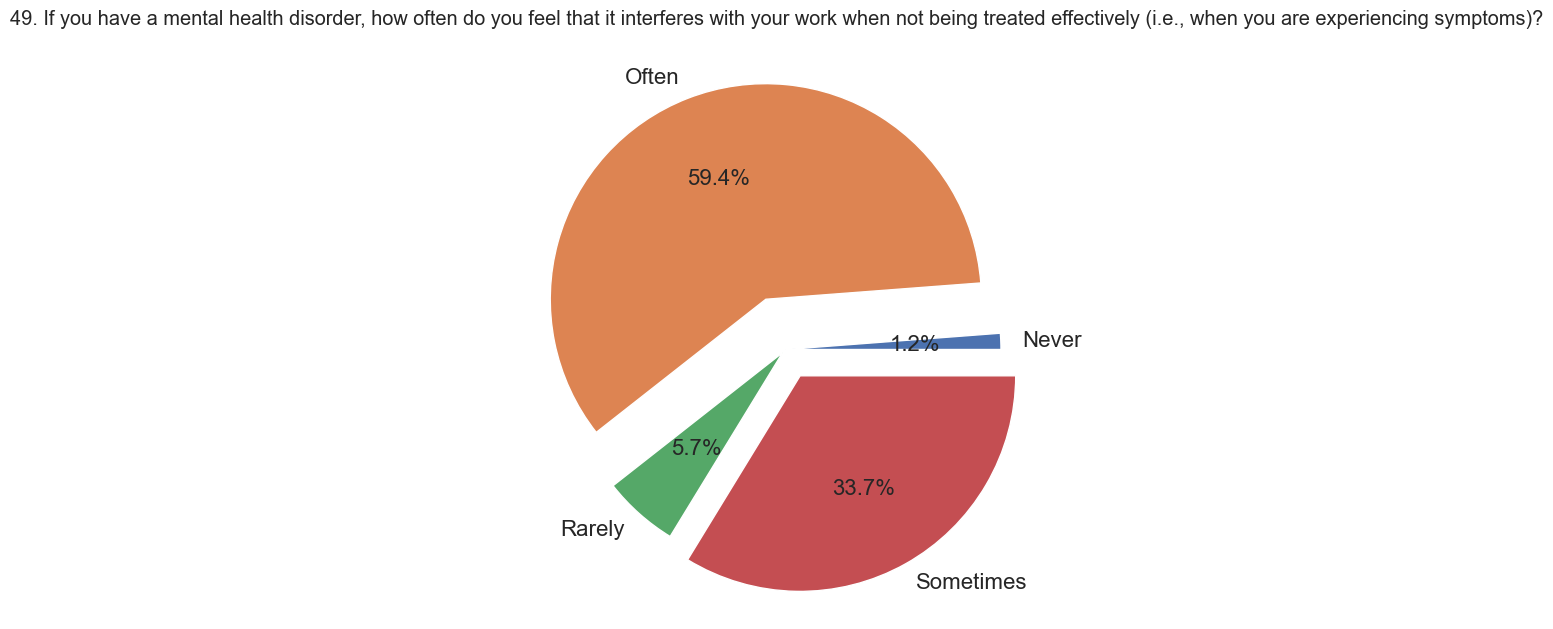

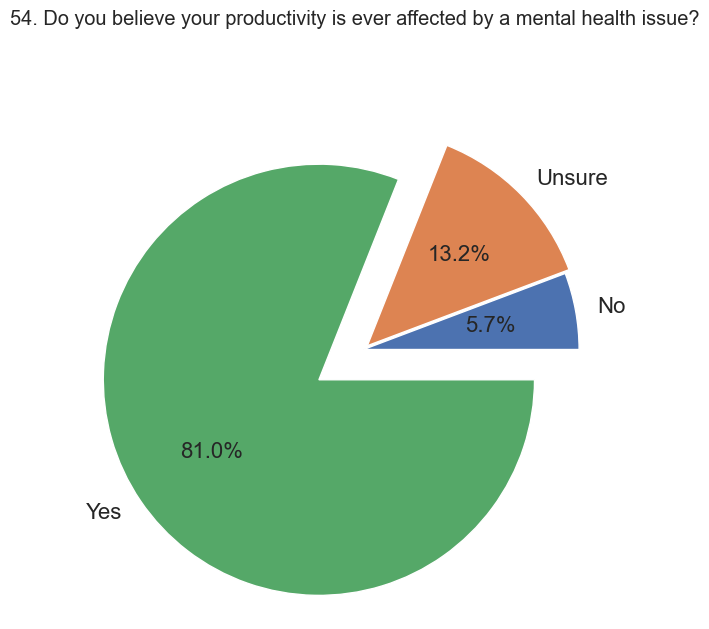

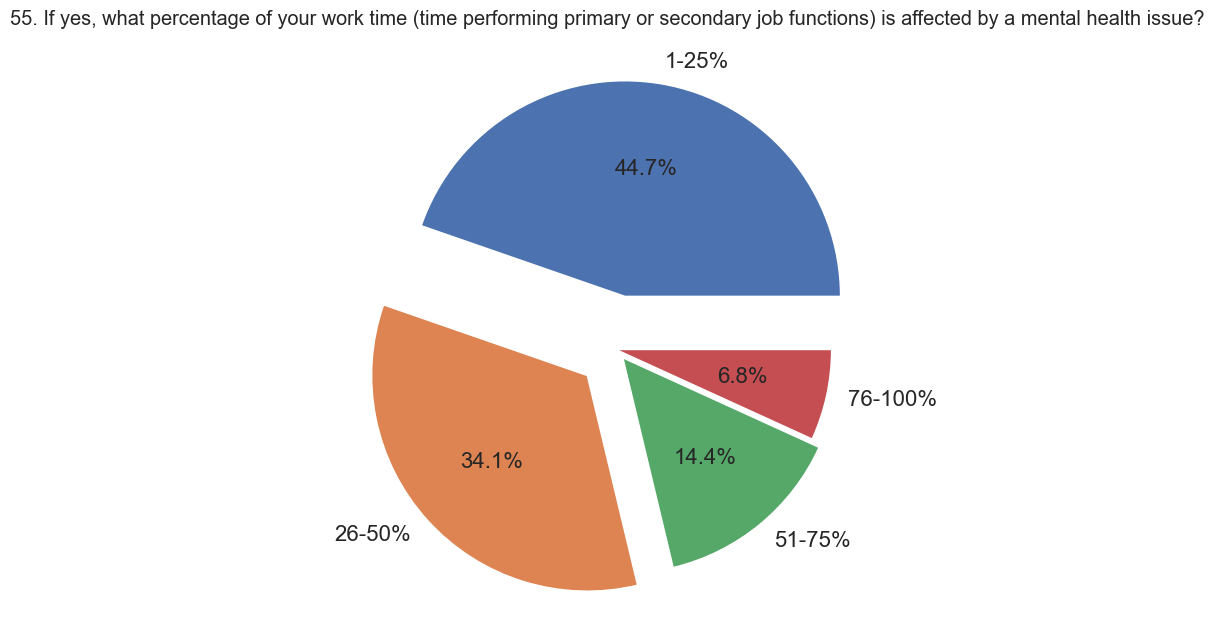

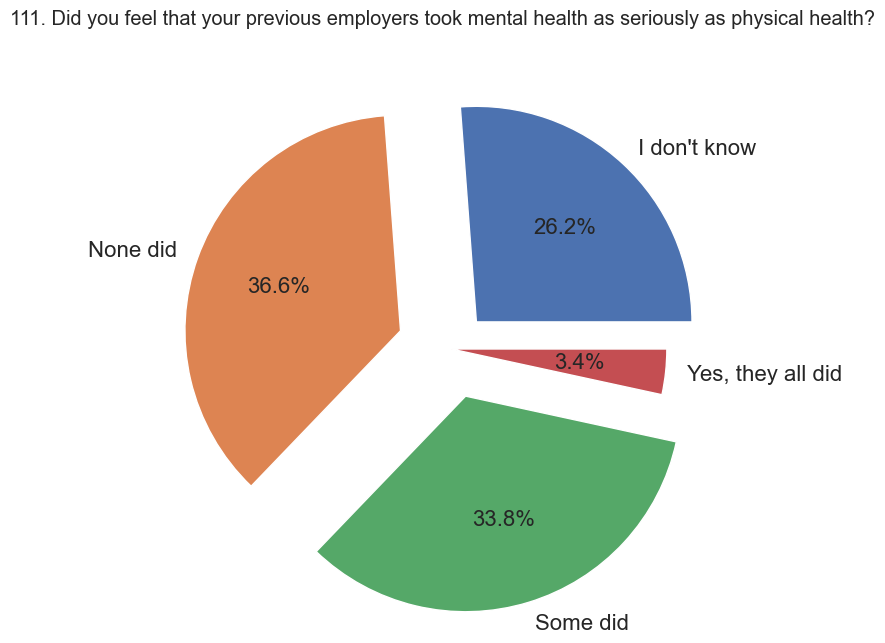

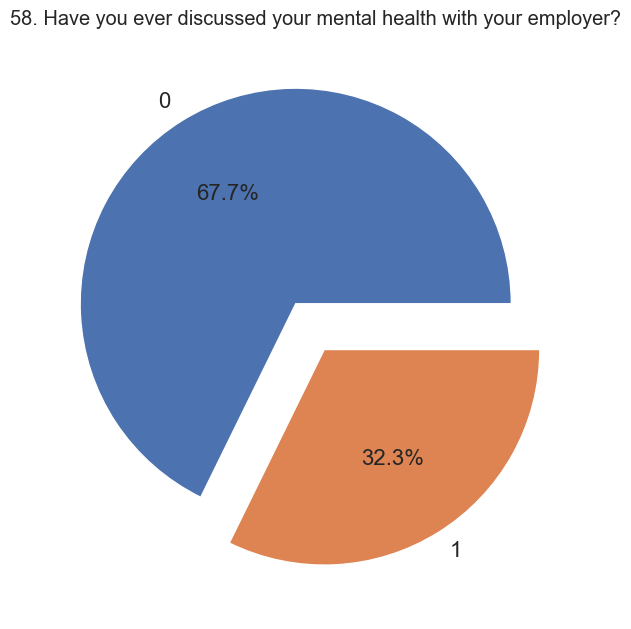

In [101]:
ans = pd.read_sql_query(f'SELECT AnswerText, QuestionID FROM Answer WHERE QuestionID IN (7, 16, 18, 19, 23, 24, 25, 26, 28, 31, 33, 48, 49, 53, 54, 55, 56, 58, 60, 65, 67, 77, 81, 83, 85, 91, 95, 96, 97, 107, 111)',con)
for q in ans.QuestionID.unique():
    if q in [7, 33, 48, 49, 54, 55, 91, 96, 16, 25, 26, 111, 58]:
        fig = plt.figure(figsize=(7,7))
        q_df = ans[(ans.QuestionID == q) & (ans.AnswerText != '-1') & ~(ans.AnswerText.str.contains('ot applicable'))]
        cnt = q_df.groupby('AnswerText').count() / q_df.shape[0]
        explode = ((cnt -cnt.min()) / (cnt.max() - cnt.min())) / 4
        if q ==  7:
            plt.pie(cnt.values.reshape(-1), explode=explode.values.reshape(-1), labels=['Yes','No'], autopct='%1.1f%%', textprops={'fontsize':16})
        else:
            plt.pie(cnt.values.reshape(-1), explode=explode.values.reshape(-1), labels=cnt.index, autopct='%1.1f%%', textprops={'fontsize':16})
        text = questions[questions.questionid == q].questiontext.values[0]
        plt.suptitle(f'{questions[questions.questionid == q].questionid.values[0]}. {text}')
        
        text_save = ('_').join(text.split(' ')[:-1])
        fig.savefig(f'{text_save}.svg')

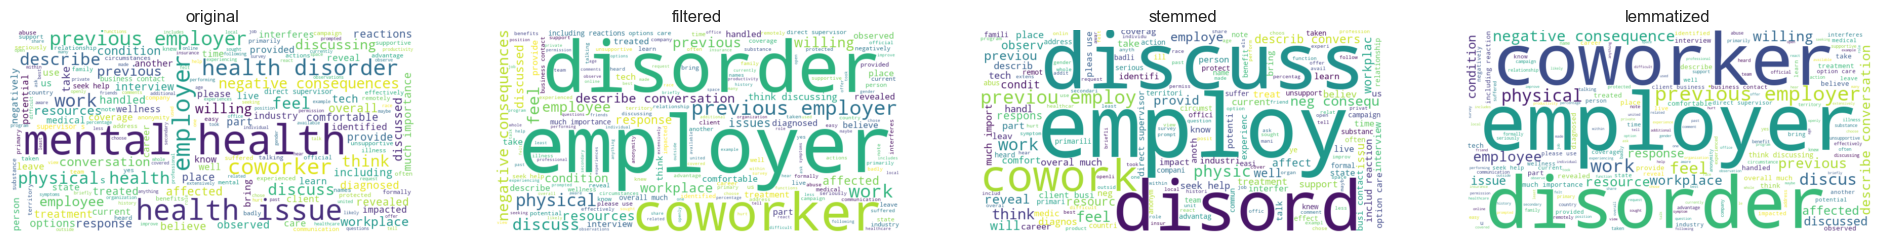

In [106]:
questions = pd.read_sql_query(f'SELECT * FROM Question', con)
mh.create_word_cloud(questions)

**- Lots of questions with the word "disorder" - they may be good target variables (i.e. diagnosis-prediction)**
<br>
**- Lots of questions with the word "employer" and "coworker" as well - they may be interesting features (i.e. how does employer/coworker treatment or relationship affect mental health?)**
- Let's see what these questions are exactly

In [6]:
disorder_df = pd.read_sql_query("""SELECT questionid id, questiontext txt
                                   FROM Question
                                   WHERE (questiontext LIKE '%disord%')
                                      OR (questiontext LIKE '%employer%')
                                      OR (questiontext LIKE '%cowork%')                                      
                                """, 
                                con)
for index, rows in disorder_df.iterrows():
    print(f'{rows.id}. {rows.txt}')

7. Have you ever sought treatment for a mental health disorder from a mental health professional?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
16. Does your employer offer resources to learn more about mental health disorders and options for seeking help?
18. Would you feel comfortable discussing a mental health issue with your coworkers?
20. Do you have medical coverage (private insurance or state-provided) that in

**Manually select some possible questions that could provide a target for classification (i.e. mental health outcome related)**

In [7]:
possible_target_questions = (7,33,34)
target_questions_df = pd.read_sql_query(f'SELECT * FROM Question WHERE questionid in {possible_target_questions}', con)
for index, rows in target_questions_df.iterrows():
    print(rows.questiontext)

Have you ever sought treatment for a mental health disorder from a mental health professional?
Do you currently have a mental health disorder?
Have you ever been diagnosed with a mental health disorder?


- How many answers do we have to each of these questions?

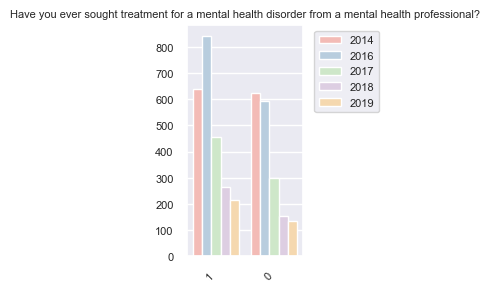

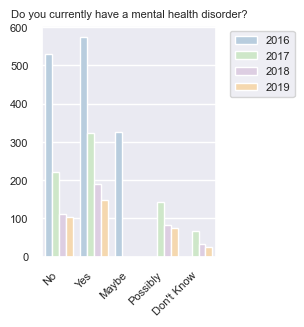

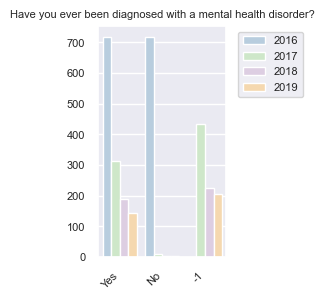

In [8]:
survey_years = pd.read_sql_query('SELECT DISTINCT(SurveyID) FROM Survey', con).values
cmap = plt.get_cmap('Pastel1')
colors_by_year = {int(survey_years[i]):cmap(x) for i, (x) in enumerate(list(range(len(survey_years))))}
sns.set()
for qid in possible_target_questions:
    question = pd.read_sql_query(f'SELECT * FROM Question WHERE QuestionID = {qid}', con)['questiontext'].values
    answer_agg = pd.read_sql_query(f"""SELECT 
                                           AnswerText, SurveyID,
                                       COUNT(*) 
                                           AS 'num'
                                       FROM
                                           Answer
                                       WHERE 
                                           QuestionID = {qid}
                                       GROUP BY
                                           AnswerText, SurveyID
                                   """,
                               con)
    answer = pd.read_sql_query(f"""SELECT *
                                   FROM
                                       Answer
                                   WHERE 
                                       QuestionID = {qid}
                                   """,
                               con)
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(0.15*answer_agg.shape[0],3))
    sns.countplot(data=answer, x='AnswerText',
                  stat='count',
                  hue='SurveyID', palette=colors_by_year, saturation=0.8,
                  ax=ax,
               )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(question[0], fontsize=8)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

- Questions that have a relatively robust availability of data:
    1. Have you ever sought treatment for a mental health disorder from a mental health professional?
    2. Do you currently have a mental health disorder?
    
**However, question 1 seems to have the least imbalance in data between the different classes, so this might be a better option to go with initially**

## 2. Deeper investigation of data availability for question 1. ##
- Since we want to know what work-related factors might influence whether someone seeks out mental health treatment or not, we will exclude people who already know that they have a mental health disorder (i.e. they have already sought out treatement)

In [78]:
current_diagnosis = 'Do you currently have a mental health disorder?'
q_to_select = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

## Get data from respondents that are not currently diagnosed with a mental disorder ##
joined_undiagnosed = pd.read_sql_query(f"""SELECT SurveyID, AnswerText, Answer.QuestionID, UserID
                               FROM Answer
                               JOIN Question
                               ON Answer.QuestionID = Question.questionid
                               WHERE UserID IN
                                    (SELECT 
                                         UserID
                                     FROM
                                         Answer
                                     LEFT JOIN
                                         Question
                                     ON
                                         Answer.QuestionID = Question.questionid
                                     WHERE
                                         (Question.questiontext = '{current_diagnosis}')
                                         AND (Answer.AnswerText NOT IN ('Yes'))
                                         );
                            """, 
                          con)

## Get data from all respondents ##
joined_all = pd.read_sql_query(f"""SELECT SurveyID, AnswerText, Answer.QuestionID, UserID
                               FROM Answer
                               JOIN Question
                               ON Answer.QuestionID = Question.questionid
                               WHERE UserID IN
                                    (SELECT 
                                         UserID
                                     FROM
                                         Answer
                                     LEFT JOIN
                                         Question
                                     ON
                                         Answer.QuestionID = Question.questionid
                                         );
                            """, 
                          con)

- Some data restructuring to get it in a feature matrix format

In [88]:
structured_data_undiagnosed = mh.structure_data(joined_undiagnosed)
structured_data_all = mh.structure_data(joined_all)

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_df['AnswerText'] = u_df['AnswerText'].replace({'-1': np.nan})
C:\Users\61407\mental-health-modelling\mh_functions.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [87]:
pd.to_pickle(structured_data_undiagnosed, 'structured_data_undiagnosed.plk')
pd.to_pickle(structured_data_all, 'structured_data_all.plk')